In [1]:
# Copyright 2016-present, Facebook, Inc.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE-examples file in the root directory of this source tree.

# Evaluate pysparnn on Enron data

In [2]:
import numpy as np
import time
import inspect

from scipy.sparse import csr_matrix
from sklearn.datasets import fetch_20newsgroups
from sklearn.neighbors import LSHForest
from sklearn.feature_extraction import DictVectorizer

In [3]:
# make sure you run 'python setup.py install' first!
import pysparnn

## Get data

In [6]:
# load enron data 
import os
import sys

docs = []
max_docs = 100000
for folder, subs, files in os.walk('maildir'):
    for filename in files:
        with open(os.path.join(folder, filename), 'r') as src:
            try:
                txt = ' '.join(src.readlines())
                if len(txt) > 0:
                    docs.append(txt)
            except:
                pass
        if len(docs) > max_docs:
            break                
    if len(docs) > max_docs:
        break

In [7]:
print('Num docs: {}'.format(len(docs)))
print('Avg doc length: {}'.format(np.mean([len(x.split()) for x in docs])))
words = set()
for doc in docs:
    words.update(doc.split())
print('Num unique words: {}'.format(len(words)))
del words

Num docs: 100001
Avg doc length: 413.6659133408666
Num unique words: 942096


## Turn documents into vectors

In [8]:
from sklearn.neighbors import LSHForest, NearestNeighbors 
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(decode_error='ignore')

features = csr_matrix(tv.fit_transform(docs))

doc_index = np.array(range(len(docs)))

In [9]:
test_features = features[:2000]
train_features = features[2000:]

## Create an answer key

In [10]:
knn = NearestNeighbors(algorithm='brute', metric='cosine')
        
knn.fit(train_features)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [11]:
t0 = time.time()
# get 1 NN for each document
answers = knn.kneighbors(test_features, n_neighbors=1, return_distance=False)
time.time() - t0

65.72836995124817

In [12]:
bknn = NearestNeighbors(algorithm='ball_tree')
        
bknn.fit(train_features)

t0 = time.time()
# get 1 NN for each document
_ = bknn.kneighbors(test_features, n_neighbors=1, return_distance=False)
time.time() - t0

/Users/spencebeecher/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:229: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


63.4017288684845

## Build models to compare

In [13]:
t0 = time.time()
snn = pysparnn.MultiClusterIndex(train_features, doc_index, num_indexes=2)
time.time() - t0

98.59879326820374

In [14]:
t0 = time.time()
lshf = LSHForest(n_neighbors=1)
        
lshf.fit(train_features)
time.time() - t0

19.502850770950317

## Compare results

In [15]:
import pysparnn_utils
import time 

In [16]:
t0 = time.time()

results = snn.search(test_features, return_distance=False)

print('Recall: {}'.format(pysparnn_utils.recall(answers, results).mean()))

snn_time = time.time() - t0
snn_time

Recall: 0.9615


19.951800107955933

In [17]:
# only search one index instead of 2
t0 = time.time()

results = snn.search(test_features, return_distance=False, num_indexes=1)

print('Recall: {}'.format(pysparnn_utils.recall(answers, results).mean()))

time.time() - t0

Recall: 0.941


11.58312177658081

In [18]:
t0 = time.time()

results = lshf.kneighbors(test_features, return_distance=False)

print('Recall: {}'.format(pysparnn_utils.recall(answers, results).mean()))
lsh_time = time.time() - t0
lsh_time

Recall: 0.7195


87.55759286880493

In [19]:
# LSH is x times slower than snn
lsh_time / snn_time

4.388455798225979

# Track Pysparnn vs Bruteforce as a function of index size

In [20]:
snn_results = []

for n in np.linspace(1000, 80000, 5):
    feats = train_features[:n]
    
    ########## brute force ############
    bf = NearestNeighbors(algorithm='brute', metric='cosine')

    bf.fit(feats)

    # get 1 NN for each document
    t0 = time.time()
    
    answers = bf.kneighbors(test_features, n_neighbors=1, return_distance=False)
    
    bf_time = time.time() - t0
    
    
    ########## snn ############
    snn = pysparnn.MultiClusterIndex(feats, doc_index, num_indexes=2)
    # only search one index instead of 2
    t0 = time.time()

    results = snn.search(test_features, return_distance=False, num_indexes=1)
    
    snn_time = time.time() - t0
    snn_recall = pysparnn_utils.recall(answers, results).mean()
    
    # results
    snn_results.append({
            'n': n,
            'snn_recall': snn_recall , 
            'snn_time': snn_time,
            'bf_recall': 1.0,
            'bf_time': bf_time
        })

/Users/spencebeecher/anaconda3/lib/python3.6/site-packages/pysparnn/matrix_distance.py:117: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 100001 but corresponding boolean dimension is 1000
  records = self.records_data[index]


In [21]:
import pandas as pd

In [24]:
%matplotlib inline

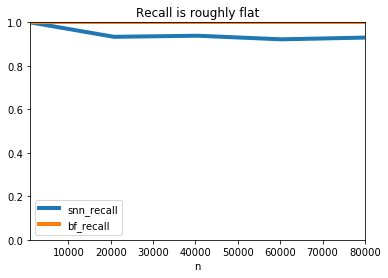

In [25]:
pd.DataFrame(snn_results)[['n', 'snn_recall', 'bf_recall']].plot(x='n', ylim=(0, 1), linewidth=4,
                                                                 title='Recall is roughly flat')

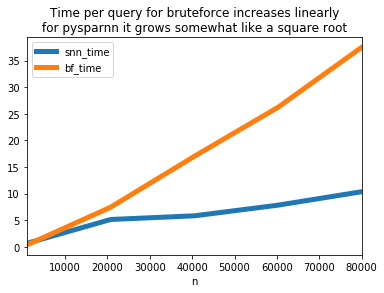

In [26]:
df = pd.DataFrame(snn_results)[['n', 'snn_time', 'bf_time']]
df.plot(x='n', linewidth=5,
        title='Time per query for bruteforce increases linearly\nfor pysparnn it grows somewhat like a square root')